In [1]:
from typing import Union
import os
import requests
import earthaccess
import pandas as pd
import datetime as dt
from datetime import date
from dateutil import parser
import geopandas
import geopandas as gpd
from shapely.geometry import MultiPolygon, Polygon, box
from shapely.geometry.polygon import orient
from emit_tools.generate_CMR_daterange_string import generate_CMR_daterange_string

In [2]:
geojson_filename = "11SPS.geojson"
start_date = "2024-05-01"
end_date = "2024-05-30"

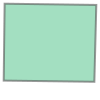

In [6]:
polygon = geopandas.read_file(geojson_filename).geometry[0]
polygon

In [11]:
def search_EMIT_L2A_reflectance(start_date: Union[date, str], end_date: Union[date, str], polygon: Polygon) -> pd.DataFrame:
    page_num = 1
    page_size = 2000 # CMR page size limit
    concept_ID = "C2408750690-LPCLOUD"
    cmrurl='https://cmr.earthdata.nasa.gov/search/' 

    temporal_str = generate_CMR_daterange_string(start_date, end_date)

    polygon = orient(polygon, sign=1.0)
    gdf = gpd.GeoDataFrame(geometry=[polygon])
    geojson = {"shapefile": ("", gdf.to_json(), "application/geo+json")}

    granule_arr = []

    while True:
        
        # defining parameters
        cmr_param = {
            "collection_concept_id": concept_ID, 
            "page_size": page_size,
            "page_num": page_num,
            "temporal": temporal_str,
            "simplify-shapefile": 'true' # this is needed to bypass 5000 coordinates limit of CMR
        }

        granulesearch = cmrurl + 'granules.json'
        response = requests.post(granulesearch, data=cmr_param, files=geojson)
        print(response)
        print(response.json())
        granules = response.json()['feed']['entry']
        
        if granules:
            for g in granules:
                granule_urls = ''
                granule_poly = ''
                        
                # read granule title and cloud cover
                granule_name = g['title']
                cloud_cover = g['cloud_cover']
        
                # reading bounding geometries
                if 'polygons' in g:
                    polygons= g['polygons']
                    multipolygons = []
                    for poly in polygons:
                        i=iter(poly[0].split (" "))
                        ltln = list(map(" ".join,zip(i,i)))
                        multipolygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in ltln]))
                    granule_poly = MultiPolygon(multipolygons)
                
                # Get https URLs to .nc files and exclude .dmrpp files
                granule_urls = [x['href'] for x in g['links'] if 'https' in x['href'] and '.nc' in x['href'] and '.dmrpp' not in x['href']]
                # Add to list
                granule_arr.append([granule_urls, cloud_cover, granule_poly])
                            
            page_num += 1
        else: 
            break
    
    # creating a pandas dataframe
    cmr_results_df = pd.DataFrame(granule_arr, columns=["asset_url", "cloud_cover", "granule_poly"])
    # Drop granules with empty geometry - if any exist
    cmr_results_df = cmr_results_df[cmr_results_df['granule_poly'] != '']
    # Expand so each row contains a single url 
    cmr_results_df = cmr_results_df.explode('asset_url')
    # Name each asset based on filename
    cmr_results_df.insert(0,'asset_name', cmr_results_df.asset_url.str.split('/',n=-1).str.get(-1))

    return cmr_results_df
    

In [12]:
search_EMIT_L2A_reflectance(start_date, end_date, polygon)

<Response [200]>
{'feed': {'updated': '2024-08-23T01:45:53.717Z', 'id': 'https://cmr.earthdata.nasa.gov:443/search/granules.json', 'title': 'ECHO granule metadata', 'entry': [{'time_start': '2024-05-21T23:27:16.000Z', 'cloud_cover': '30', 'updated': '2024-05-23T23:03:47.000Z', 'dataset_id': 'EMIT L2A Estimated Surface Reflectance and Uncertainty and Masks 60 m V001', 'data_center': 'LPCLOUD', 'title': 'EMIT_L2A_RFL_001_20240521T232716_2414216_002', 'coordinate_system': 'GEODETIC', 'day_night_flag': 'DAY', 'time_end': '2024-05-21T23:27:28.000Z', 'id': 'G3029286621-LPCLOUD', 'original_format': 'UMM_JSON', 'granule_size': '3579.7861518859863', 'browse_flag': True, 'polygons': [['33.5352974 -115.9862595 32.9145088 -116.7228775 32.3046684 -116.208931 32.925457 -115.4723129 33.5352974 -115.9862595']], 'collection_concept_id': 'C2408750690-LPCLOUD', 'online_access_flag': True, 'links': [{'rel': 'http://esipfed.org/ns/fedsearch/1.1/data#', 'title': 'Download EMIT_L2A_RFL_001_20240521T232716_24

,asset_name,asset_url,cloud_cover,granule_poly
0,EMIT_L2A_RFL_001_20240521T232716_2414216_002.nc,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,30,"MULTIPOLYGON (((-115.9862595 33.5352974, -116...."
0,EMIT_L2A_RFLUNCERT_001_20240521T232716_2414216...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,30,"MULTIPOLYGON (((-115.9862595 33.5352974, -116...."
0,EMIT_L2A_MASK_001_20240521T232716_2414216_002.nc,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,30,"MULTIPOLYGON (((-115.9862595 33.5352974, -116...."
1,EMIT_L2A_RFL_001_20240521T232728_2414216_003.nc,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,20,"MULTIPOLYGON (((-115.3462372 34.0547523, -116...."
1,EMIT_L2A_RFLUNCERT_001_20240521T232728_2414216...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,20,"MULTIPOLYGON (((-115.3462372 34.0547523, -116...."
1,EMIT_L2A_MASK_001_20240521T232728_2414216_003.nc,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,20,"MULTIPOLYGON (((-115.3462372 34.0547523, -116...."
2,EMIT_L2A_RFL_001_20240521T232740_2414216_004.nc,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,8,"MULTIPOLYGON (((-114.7049332 34.5700073, -115...."
2,EMIT_L2A_RFLUNCERT_001_20240521T232740_2414216...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,8,"MULTIPOLYGON (((-114.7049332 34.5700073, -115...."
2,EMIT_L2A_MASK_001_20240521T232740_2414216_004.nc,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,8,"MULTIPOLYGON (((-114.7049332 34.5700073, -115...."
